# A/B test 1 - loved journeys, control vs content similarity sorted list

This related links A/B test (ab1) was conducted from 13-21th Feb 2019.
The data used in this report are 14-20th Feb 2019 because on 13th the split was not 50:50 and the text was ended mid-morning on 21st Feb.

The test compared the existing related links (where available) to links generated using Google's universal sentence encoder V2. The first 300 words of content tagged to the topic taxonomy (labelled.csv.gz) were encoded and cosine distance was used to find the nearest vector to each content vector. A maximum of 5 links were suggested and only links above a threshold of 0.15 were suggested. 

16% of labelled content did not recieve any suggested links and 63% of content received 5 suggested links:

| number of suggested links | % pages with this number of links |
|--:|----:|
| 0 | 16% |
| 1 |  8% |
| 2 |  5% |
| 3 | 4%  |
| 4 | 3%  |
| 5 | 63% |

## Import

In [76]:
  
import os 
import pandas as pd
import numpy as np
import ast
import re

# z test
from statsmodels.stats.proportion import proportions_ztest

# bayesian bootstrap and vis
import matplotlib.pyplot as plt
import seaborn as sns
import bayesian_bootstrap.bootstrap as bb
from astropy.utils import NumpyRNGContext

# progress bar
from tqdm import tqdm, tqdm_notebook

from scipy import stats
from collections import Counter

# set up the style for our plots
sns.set(style='white', palette='colorblind', font_scale=1.3,
        rc={'figure.figsize':(12,9), 
            "axes.facecolor": (0, 0, 0, 0)})

# instantiate progress bar goodness
tqdm.pandas(tqdm_notebook)

pd.set_option('max_colwidth',500)

# the number of bootstrap means used to generate a distribution
boot_reps = 10000

# alpha - false positive rate
alpha = 0.05
# number of tests
m = 4
# Correct alpha for multiple comparisons
alpha = alpha / m

# The Bonferroni correction can be used to adjust confidence intervals also. 
# If one establishes m confidence intervals, and wishes to have an overall confidence level of 1-alpha,
# each individual confidence interval can be adjusted to the level of 1-(alpha/m).

# reproducible
seed = 1337

import sys
sys.path.insert(0, '../../src' )
import analysis as analysis

## File/dir locations
### Processed journey data

In [4]:
DATA_DIR = os.getenv("DATA_DIR")
filename = "full_sample_loved_947858.csv.gz"
filepath = os.path.join(
    DATA_DIR, "sampled_journey",
    "20190214_20190220",
    filename)
filepath

'/Users/ellieking/Documents/govuk_ab_analysis/data/sampled_journey/20190214_20190220/full_sample_loved_947858.csv.gz'

In [5]:
# read in processed sampled journey with just the cols we need for related links
df = pd.read_csv(filepath, sep ="\t", compression="gzip")
# convert from str to list
df['Event_cat_act_agg']= df['Event_cat_act_agg'].progress_apply(ast.literal_eval)
df['Page_Event_List'] = df['Page_Event_List'].progress_apply(ast.literal_eval)
df['Page_List'] = df['Page_List'].progress_apply(ast.literal_eval)

100%|██████████| 729881/729881 [00:19<00:00, 36918.10it/s]


In [ ]:
df['Page_List_Length'] = df['Page_List'].progress_apply(len)


In [ ]:
# drop dodgy rows, where page variant is not A or B. 
df = df.query('ABVariant in ["A", "B"]')

### Nav type of page lookup - is it a finding page? if not it's a thing page

In [6]:
filename = "document_types.csv.gz"

# created a metadata dir in the DATA_DIR to hold this data
filepath = os.path.join(
    DATA_DIR, "metadata",
    filename)
print(filepath)

df_finding_thing = pd.read_csv(filepath, sep="\t", compression="gzip")

df_finding_thing.head()

/Users/ellieking/Documents/govuk_ab_analysis/data/metadata/document_types.csv.gz


,pagePath,is_finding
0,/jobsearch,0
1,/pay-leave-for-parents/y,0
2,/student-finance-calculator/y/2018-2019/uk-full-time,0
3,/government/publications/application-for-confirmation-of-british-nationality-status-form-ns,0
4,/pip/eligibility,0


In [7]:
thing_page_paths = df_finding_thing[
    df_finding_thing['is_finding']==0]['pagePath'].tolist()


finding_page_paths = df_finding_thing[
    df_finding_thing['is_finding']==1]['pagePath'].tolist()

## Outliers
Some rows should be removed before analysis. For example rows with journey lengths of 500 or very high related link click rates. This process might have to happen once features have been created.

# Derive variables

## Journeys using related links
There is no difference in the proportion of journeys using at least one related link (journey_click_rate) between page variant A and page variant B.



\begin{equation*}
\frac{\text{total number of journeys including at least one click on a related link}}{\text{total number of journeys}}
\end{equation*}

In [17]:
# get the number of related links clicks per Sequence
df['Related Links Clicks per seq'] = df['Event_cat_act_agg'].map(analysis.sum_related_click_events)

In [18]:
# map across the Sequence variable, which includes pages and Events
# we want to pass all the list elements to a function one-by-one and then collect the output.
df["Has_Related"] = df["Related Links Clicks per seq"].map(analysis.is_related)

df['Related Links Clicks row total'] = df['Related Links Clicks per seq'] * df['Occurrences']


## count of clicks on navigation elements

There is no statistically significant difference in the count of clicks on navigation elements per journey between page variant A and page variant B.

\begin{equation*}
{\text{total number of navigation element click events from content pages}}
\end{equation*}

### Navigation events

In [12]:
def count_nav_events(page_event_list):
    """Counts the number of nav events from a content page in a Page Event List."""
    content_page_nav_events = 0
    for pair in page_event_list:
        if analysis.is_nav_event(pair[1]):
            if pair[0] in thing_page_paths:
                content_page_nav_events += 1
    return content_page_nav_events

In [13]:
# needs finding_thing_df read in from document_types.csv.gz
df['Content_Page_Nav_Event_Count'] = df['Page_Event_List'].progress_map(count_nav_events,)




  0%|          | 0/729881 [00:00<?, ?it/s]


  0%|          | 39/729881 [00:00<49:13, 247.15it/s]


  0%|          | 47/729881 [00:00<3:06:13, 65.32it/s]


  0%|          | 53/729881 [00:00<6:09:25, 32.93it/s]


  0%|          | 69/729881 [00:00<4:43:33, 42.90it/s]


  0%|          | 176/729881 [00:01<3:22:15, 60.13it/s]


  0%|          | 211/729881 [00:01<2:40:56, 75.56it/s]


  0%|          | 241/729881 [00:01<2:04:50, 97.41it/s]


  0%|          | 271/729881 [00:01<1:42:05, 119.12it/s]


  0%|          | 300/729881 [00:01<1:26:30, 140.56it/s]


  0%|          | 328/729881 [00:01<1:19:18, 153.32it/s]


  0%|          | 353/729881 [00:01<1:15:19, 161.41it/s]


  0%|          | 398/729881 [00:02<1:01:25, 197.91it/s]


  0%|          | 508/729881 [00:02<46:29, 261.48it/s]  


  0%|          | 608/729881 [00:02<36:38, 331.73it/s]


  0%|          | 671/729881 [00:02<37:38, 322.93it/s]

KeyboardInterrupt: 




  0%|          | 713/729881 [00:16<37:38, 322.93it/s]

In [14]:
def count_search_from_content(page_list):
    search_from_content = 0
    for i, page in enumerate(page_list):
        if i > 0:
            if '/search?q=' in page:
                if page_list[i-1] in thing_page_paths:
                    search_from_content += 1
    return search_from_content

In [15]:
df['Content_Search_Event_Count'] = df['Page_List'].progress_map(count_search_from_content)





  0%|          | 0/729881 [00:00<?, ?it/s]



  0%|          | 1/729881 [00:00<25:56:05,  7.82it/s]



  0%|          | 14/729881 [00:00<18:42:26, 10.84it/s]



  0%|          | 45/729881 [00:00<13:26:44, 15.08it/s]



  0%|          | 53/729881 [00:00<11:28:49, 17.66it/s]



  0%|          | 65/729881 [00:00<8:42:27, 23.28it/s] 



  0%|          | 73/729881 [00:00<7:19:00, 27.71it/s]



  0%|          | 85/729881 [00:01<5:41:48, 35.59it/s]



  0%|          | 164/729881 [00:01<4:07:28, 49.14it/s]



  0%|          | 183/729881 [00:01<3:24:35, 59.44it/s]



  0%|          | 235/729881 [00:01<2:31:49, 80.10it/s]



  0%|          | 260/729881 [00:01<2:16:37, 89.00it/s]



  0%|          | 288/729881 [00:01<1:51:44, 108.83it/s]



  0%|          | 311/729881 [00:02<1:36:20, 126.22it/s]



  0%|          | 332/729881 [00:02<1:38:48, 123.06it/s]



  0%|          | 351/729881 [00:02<1:37:35, 124.58it/s]



  0%|          | 368/729881 [00:02<1:31:18, 133.17it/s]



  0%|          | 393

KeyboardInterrupt: 





  0%|          | 537/729881 [00:24<7:44:48, 26.15it/s]

### Generate the derived metrics

In [ ]:
# count of nav or search clicks
df['Content_Nav_or_Search_Count'] = df['Content_Page_Nav_Event_Count'] + df['Content_Search_Event_Count']
# occurrences is accounted for by the group by bit in our bayesian boot analysis function
df['Content_Nav_Search_Event_Sum_row_total'] = df['Content_Nav_or_Search_Count'] * df['Occurrences']
# required for journeys with no nav later
df['Has_No_Nav_Or_Search'] = df['Content_Nav_Search_Event_Sum_row_total'] == 0

## Temporary df file in case of crash
### Save

In [32]:
# create temp file incase we crash after all that hard work
filepath = os.path.join(
    DATA_DIR, "loved_temp.csv.gz")

In [ ]:
df.to_csv(filepath, sep="\t", compression="gzip", index=False)

In [33]:
# df = pd.read_csv(filepath, sep="\t", compression="gzip")

# Frequentist statistics

#### Statistical significance

In [29]:
# help(proportions_ztest)

In [35]:
has_rel = analysis.z_prop(df, 'Has_Related')
has_rel

{'metric_name': 'Has_Related',
 'stats_method': 'z_prop_test',
 'x_ab': 63103,
 'n_ab': 1895715,
 'p': 0.033287176606188164,
 'x_a': 34552,
 'n_a': 947858,
 'p_a': 0.036452717601159666,
 'x_b': 28551,
 'n_b': 947857,
 'p_b': 0.03012163227153463,
 'test_statistic': 24.296710256339416,
 'p-value': 2.123739144919768e-130}

In [36]:
has_rel['p-value'] < alpha

True

#### Practical significance - uplift

In [37]:
print("There was a {0:.2f}% relative change from A to B".format(((has_rel['p_b'] - has_rel['p_a'])/has_rel['p_a'])*100))

There was a -17.37% relative change from A to B


In [38]:
# Due to multiple testing we used the Bonferroni correction for alpha
ci_low,ci_upp = analysis.zconf_interval_two_samples(has_rel['x_a'], has_rel['n_a'],
                                           has_rel['x_b'], has_rel['n_b'], alpha = alpha)
print(' difference in proportions = {0:.2f}%'.format(100*(has_rel['p_b']-has_rel['p_a'])))
print(' 95% Confidence Interval = ( {0:.2f}% , {1:.2f}% )'
      .format(100*ci_low, 100*ci_upp))

 difference in proportions = -0.63%
 95% Confidence Interval = ( -0.70% , -0.57% )


### Bayesian statistics 

Based on [this](https://medium.com/@thibalbo/coding-bayesian-ab-tests-in-python-e89356b3f4bd) blog

To be developed, a Bayesian approach can provide a simpler interpretation.

### Bayesian bootstrap

In [39]:
analysis.compare_total_searches(df)

total searches in A = 58353
total searches in B = 61281
B has 2928 more navigation or searches than A a 2.45% overall difference
The relative change was 5.02% from A to B


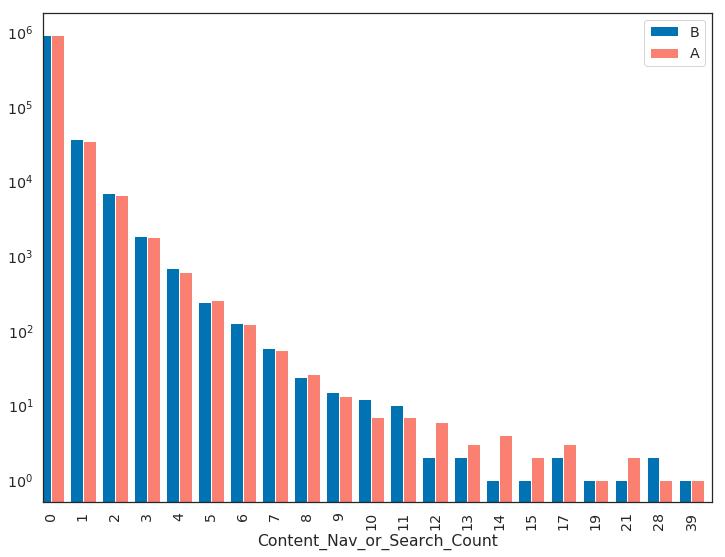

In [40]:
fig, ax = plt.subplots()
plot_df_B = df[df.ABVariant == "B"].groupby(
            'Content_Nav_or_Search_Count').sum().iloc[:, 0]
plot_df_A = df[df.ABVariant == "A"].groupby(
            'Content_Nav_or_Search_Count').sum().iloc[:, 0]

ax.set_yscale('log')
width =0.4
ax = plot_df_B.plot.bar(label='B', position=1, width=width)
ax = plot_df_A.plot.bar(label='A', color='salmon', position=0, width=width)

legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show();

In [41]:
a_bootstrap, b_bootstrap = analysis.bayesian_bootstrap_analysis(df, col_name='Content_Nav_or_Search_Count', boot_reps=boot_reps, seed = seed)

In [42]:
# ratio is vestigial but we keep it here for convenience
# it's actually a count but considers occurrences
ratio_stats = analysis.bb_hdi(a_bootstrap, b_bootstrap, alpha=alpha)
ratio_stats

{'a_ci_low': 0.060655967647694715,
 'a_ci_hi': 0.062369218900331085,
 'b_ci_low': 0.06380446879062295,
 'b_ci_hi': 0.06557925229054415,
 'diff_mean': 0.003086359071801413,
 'diff_ci_low': 0.0018438638579233446,
 'diff_ci_hi': 0.004319120460152814,
 'prob_b_>_a': 1.0}

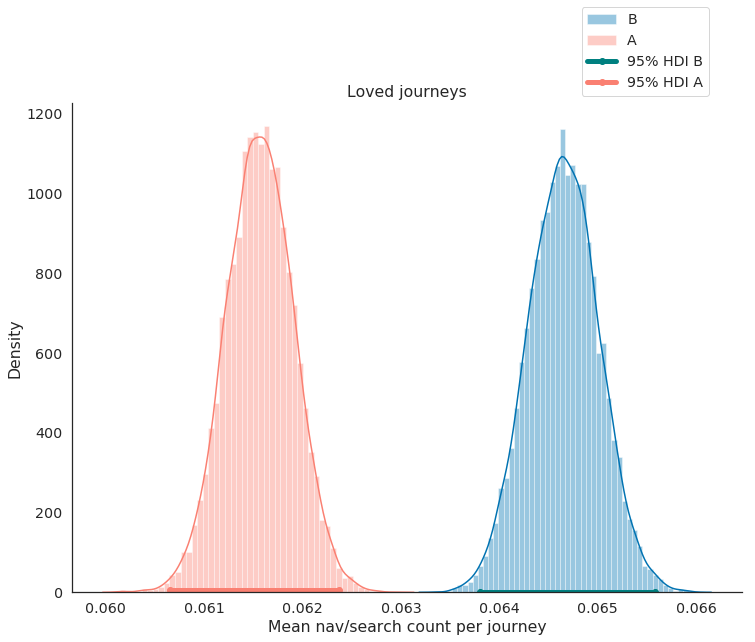

In [43]:
ax = sns.distplot(b_bootstrap, label='B')
ax.errorbar(x=[ratio_stats['b_ci_low'], ratio_stats['b_ci_hi']], y=[2, 2], linewidth=5, c='teal', marker='o', 
         label='95% HDI B')

ax = sns.distplot(a_bootstrap, label='A', ax=ax, color='salmon')
ax.errorbar(x=[ratio_stats['a_ci_low'], ratio_stats['a_ci_hi']], y=[5, 5], linewidth=5, c='salmon', marker='o', 
         label='95% HDI A')

# ax.set(xlabel='mean Content_Nav_or_Search_Count per session', ylabel='Density')
sns.despine()
legend = plt.legend(frameon=True,  bbox_to_anchor=(0.75, 1), loc='best')
frame = legend.get_frame()
frame.set_facecolor('white')
plt.title("Loved journeys")
plt.xlabel('Mean nav/search count per journey')
plt.ylabel('Density')

plt.savefig('nav_counts_loved.png', dpi = 300, bbox_inches = 'tight')

In [44]:
# calculate the posterior for the difference between A's and B's ratio
# ypa prefix is vestigial from blog post
ypa_diff = np.array(b_bootstrap) - np.array(a_bootstrap)
# get the hdi
ypa_diff_ci_low, ypa_diff_ci_hi = bb.highest_density_interval(ypa_diff)

# the mean of the posterior
print('mean:', ypa_diff.mean())

print('low ci:', ypa_diff_ci_low, '\nhigh ci:', ypa_diff_ci_hi)

mean: 0.003086359071801413
low ci: 0.002111643228063377 
high ci: 0.004042105315009127


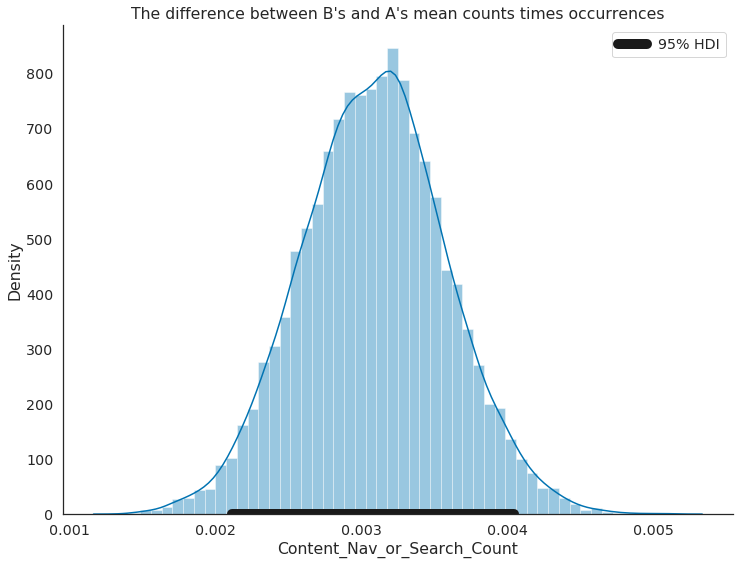

In [45]:
ax = sns.distplot(ypa_diff)
ax.plot([ypa_diff_ci_low, ypa_diff_ci_hi], [0, 0], linewidth=10, c='k', marker='o', 
         label='95% HDI')
ax.set(xlabel='Content_Nav_or_Search_Count', ylabel='Density', 
       title='The difference between B\'s and A\'s mean counts times occurrences')
sns.despine()
legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show();

In [46]:
# We count the number of values greater than 0 and divide by the total number
# of observations
# which returns us the the proportion of values in the distribution that are
# greater than 0, could act a bit like a p-value
(ypa_diff > 0).sum() / ypa_diff.shape[0]

1.0

In [47]:
# We count the number of values less than 0 and divide by the total number
# of observations
# which returns us the the proportion of values in the distribution that are
# less than 0, could act a bit like a p-value
(ypa_diff < 0).sum() / ypa_diff.shape[0]

0.0

In [48]:
(ypa_diff>0).sum()

10000

In [49]:
(ypa_diff<0).sum()

0

## proportion of journeys with a page sequence including content and related links only

There is no statistically significant difference in the proportion of journeys with a page sequence including content and related links only (including loops) between page variant A and page variant B

\begin{equation*}
\frac{\text{total number of journeys that only contain content pages and related links (i.e. no nav pages)}}{\text{total number of journeys}}
\end{equation*}

### Overall

In [50]:
# if (Content_Nav_Search_Event_Sum == 0) that's our success
# Has_No_Nav_Or_Search == 1 is a success
# the problem is symmetrical so doesn't matter too much
sum(df.Has_No_Nav_Or_Search * df.Occurrences) / df.Occurrences.sum()

0.9526648256726354

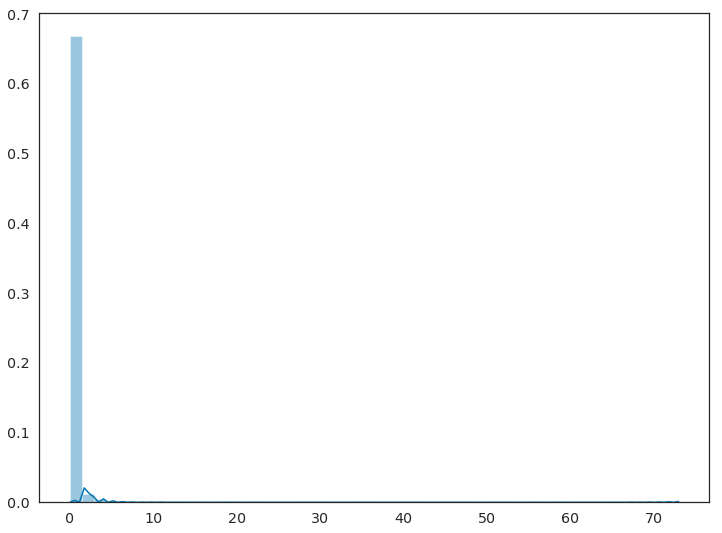

In [51]:
sns.distplot(df.Content_Nav_or_Search_Count.values);

### Frequentist statistics
#### Statistical significance

In [52]:
nav = analysis.z_prop(df, 'Has_No_Nav_Or_Search')
nav

{'metric_name': 'Has_No_Nav_Or_Search',
 'stats_method': 'z_prop_test',
 'x_ab': 1805981,
 'n_ab': 1895715,
 'p': 0.9526648256726354,
 'x_a': 904071,
 'n_a': 947858,
 'p_a': 0.9538042618198085,
 'x_b': 901910,
 'n_b': 947857,
 'p_b': 0.9515253883233441,
 'test_statistic': 7.387792508039292,
 'p-value': 1.4928645915600516e-13}

#### Practical significance - uplift

In [53]:
# function defined earlier in notebook

# Due to multiple testing we used the Bonferroni correction for alpha
ci_low,ci_upp = analysis.zconf_interval_two_samples(nav['x_a'], nav['n_a'],
                                           nav['x_b'], nav['n_b'], alpha = alpha)
diff = 100*(nav['p_b']-nav['p_a'])
print(' difference in proportions = {0:.2f}%'.format(diff))
print(' 95% Confidence Interval = ( {0:.2f}% , {1:.2f}% )'
      .format(100*ci_low, 100*ci_upp))

 difference in proportions = -0.23%
 95% Confidence Interval = ( -0.30% , -0.15% )


In [54]:
print("There was a {0: .2f}% relative change in the proportion of journeys not using search/nav elements".format(100 * ((nav['p_b']-nav['p_a'])/nav['p_a'])))

There was a -0.24% relative change in the proportion of journeys not using search/nav elements


In [55]:
nav['x_a']/nav['n_a']

0.9538042618198085

## Average Journey Length (number of page views)
There is no statistically significant difference in the average page list length of journeys (including loops) between page variant A and page variant B.

In [56]:
length_B = df[df.ABVariant == "B"].groupby(
            'Page_List_Length').sum().iloc[:, 0]
lengthB_2 = length_B.reindex(np.arange(1, 501, 1), fill_value=0)

length_A = df[df.ABVariant == "A"].groupby(
            'Page_List_Length').sum().iloc[:, 0]
lengthA_2 = length_A.reindex(np.arange(1, 501, 1), fill_value=0)

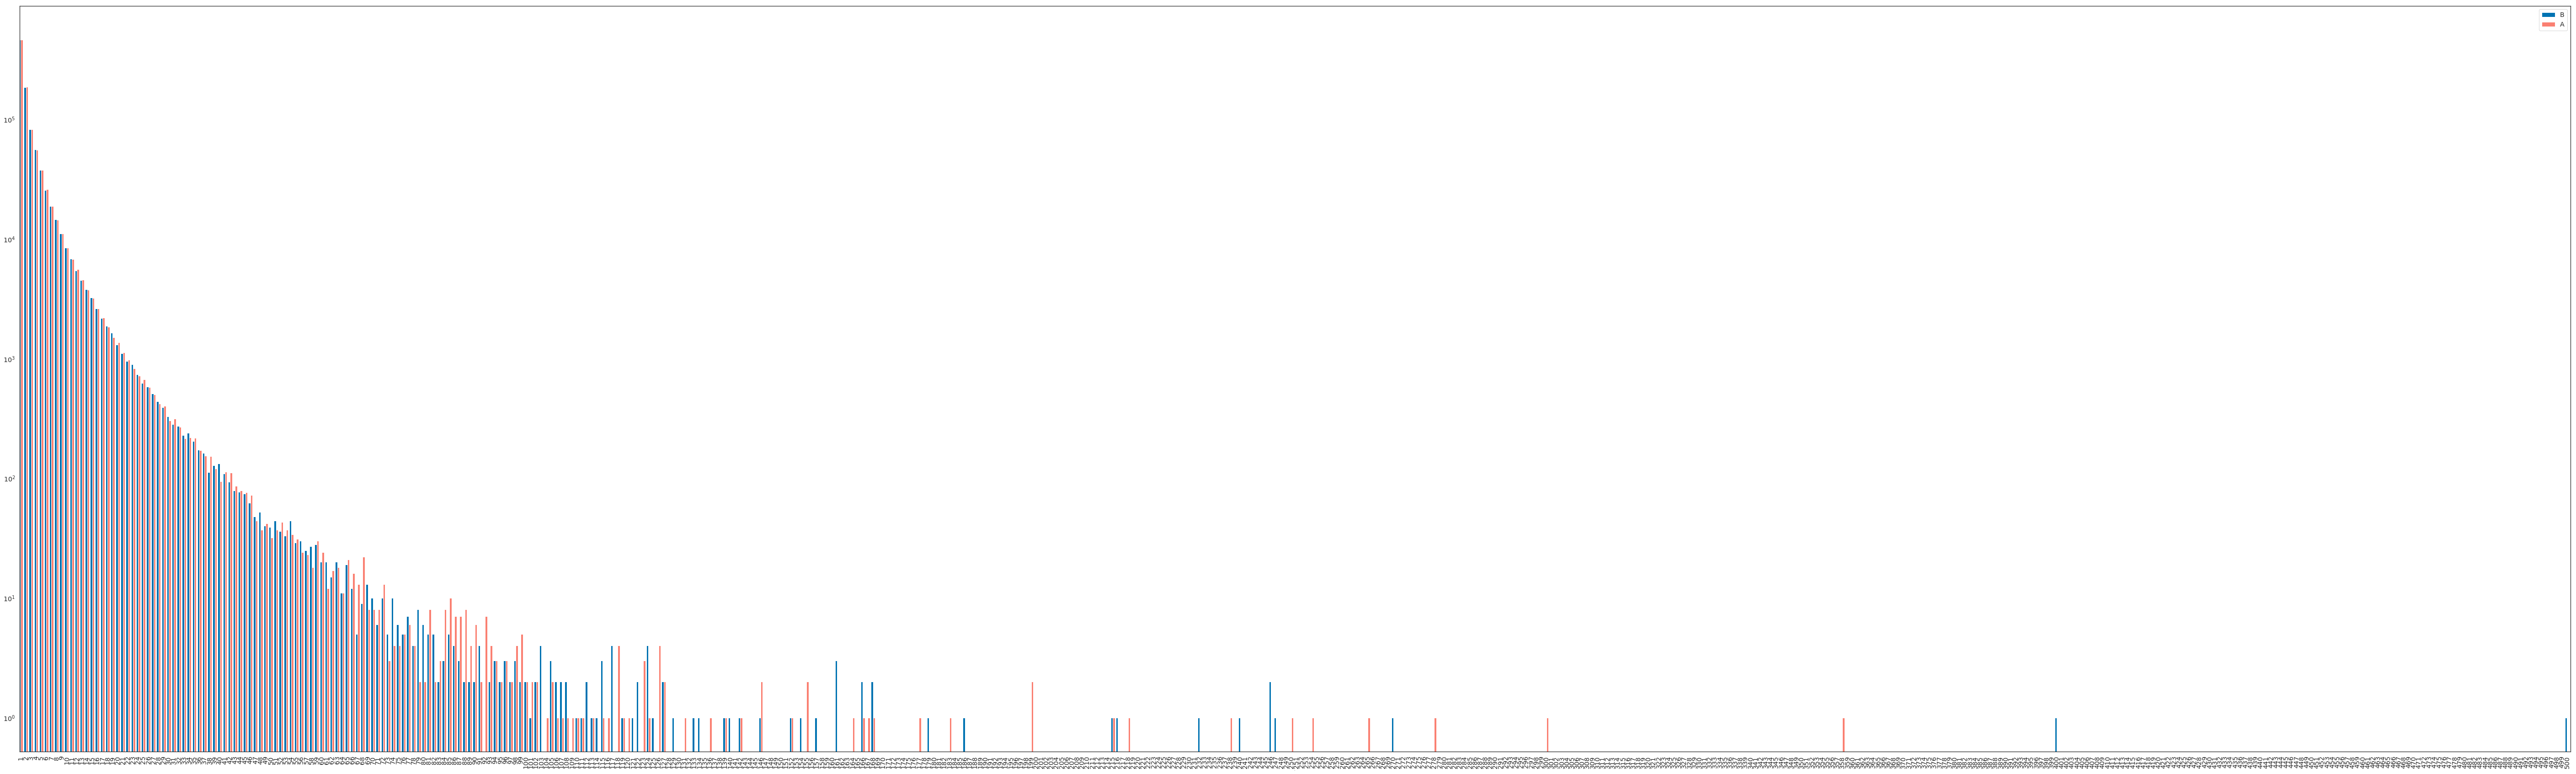

In [57]:
fig, ax = plt.subplots(figsize=(100, 30))

ax.set_yscale('log')
width = 0.4
ax = lengthB_2.plot.bar(label='B', position=1, width=width)
ax = lengthA_2.plot.bar(label='A', color='salmon', position=0, width=width)
plt.xlabel('length', fontsize=1)
legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show();

### Bayesian bootstrap for non-parametric hypotheses

In [58]:
# http://savvastjortjoglou.com/nfl-bayesian-bootstrap.html

In [59]:
# let's use mean journey length (could probably model parametrically but we use it for demonstration here)
# some journeys have length 500 and should probably be removed as they are liekely bots or other weirdness

In [60]:
print("The mean number of pages in an loved jounrey is {0:.3f}".format(sum(df.Page_List_Length*df.Occurrences)/df.Occurrences.sum()))

The mean number of pages in an loved jounrey is 3.007


In [61]:
# for reproducibility, set the seed within this context
a_bootstrap, b_bootstrap = analysis.bayesian_bootstrap_analysis(df, col_name='Page_List_Length', boot_reps=boot_reps, seed = seed)

In [62]:
np.array(a_bootstrap).mean()

3.007935021757485

In [63]:
np.array(b_bootstrap).mean()

3.006429590126311

In [64]:
print("There's a relative change in page length of {0:.2f}% from A to B".format((np.array(b_bootstrap).mean()-np.array(a_bootstrap).mean())/np.array(a_bootstrap).mean()*100))

There's a relative change in page length of -0.05% from A to B


In [65]:
# Calculate a 95% HDI
a_ci_low, a_ci_hi = bb.highest_density_interval(a_bootstrap)
print('low ci:', a_ci_low, '\nhigh ci:', a_ci_hi)

low ci: 2.9991571034372417 
high ci: 3.016674823852333


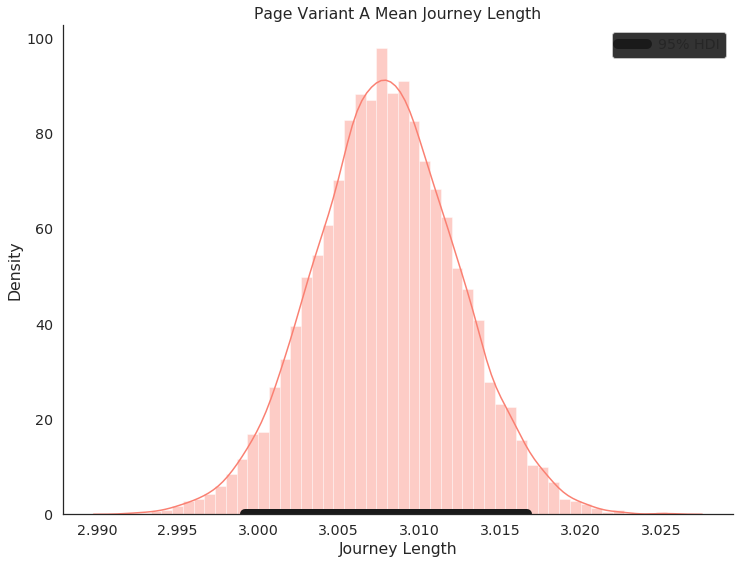

In [66]:
ax = sns.distplot(a_bootstrap, color='salmon')
ax.plot([a_ci_low, a_ci_hi], [0, 0], linewidth=10, c='k', marker='o', 
         label='95% HDI')
ax.set(xlabel='Journey Length', ylabel='Density', title='Page Variant A Mean Journey Length')
sns.despine()
plt.legend();

In [67]:
# Calculate a 95% HDI
b_ci_low, b_ci_hi = bb.highest_density_interval(b_bootstrap)
print('low ci:', b_ci_low, '\nhigh ci:', b_ci_hi)

low ci: 2.997657500417135 
high ci: 3.0154144381182406


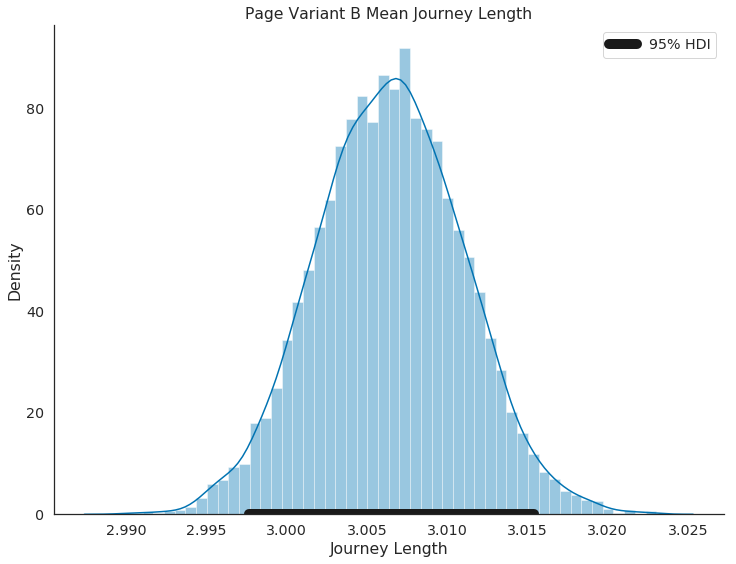

In [68]:
ax = sns.distplot(b_bootstrap)
ax.plot([b_ci_low, b_ci_hi], [0, 0], linewidth=10, c='k', marker='o', 
         label='95% HDI')
ax.set(xlabel='Journey Length', ylabel='Density', title='Page Variant B Mean Journey Length')
sns.despine()
legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show();

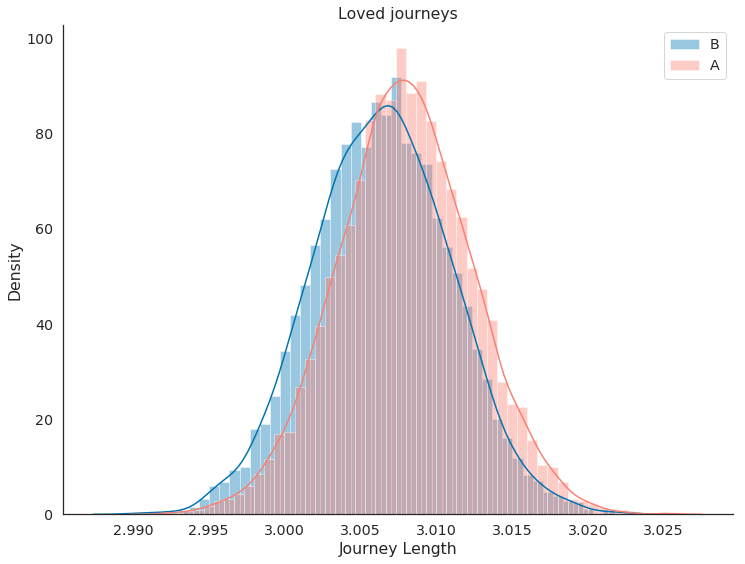

In [69]:
ax = sns.distplot(b_bootstrap, label='B')
ax = sns.distplot(a_bootstrap, label='A', ax=ax, color='salmon')
ax.set(xlabel='Journey Length', ylabel='Density')
sns.despine()
legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.title("Loved journeys")

plt.savefig('journey_length_loved.png', dpi = 900, bbox_inches = 'tight')

We can also measure the uncertainty in the difference between the Page Variants's Journey Length by subtracting their posteriors.



In [70]:
# calculate the posterior for the difference between A's and B's YPA
ypa_diff = np.array(b_bootstrap) - np.array(a_bootstrap)
# get the hdi
ypa_diff_ci_low, ypa_diff_ci_hi = bb.highest_density_interval(ypa_diff)

In [71]:
# the mean of the posterior
ypa_diff.mean()

-0.0015054316311740893

In [72]:
print('low ci:', ypa_diff_ci_low, '\nhigh ci:', ypa_diff_ci_hi)


low ci: -0.014038346934665658 
high ci: 0.010780056495092616


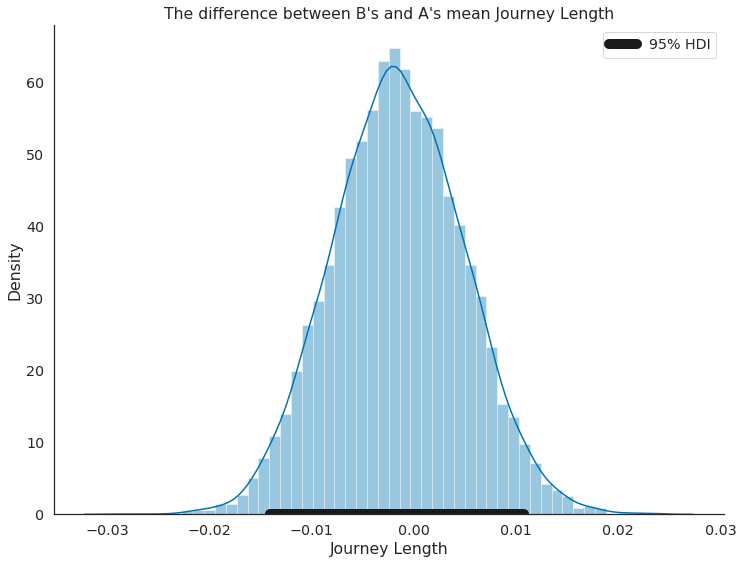

In [73]:
ax = sns.distplot(ypa_diff)
ax.plot([ypa_diff_ci_low, ypa_diff_ci_hi], [0, 0], linewidth=10, c='k', marker='o', 
         label='95% HDI')
ax.set(xlabel='Journey Length', ylabel='Density', 
       title='The difference between B\'s and A\'s mean Journey Length')
sns.despine()
legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show();

We can actually calculate the probability that B's mean Journey Length was greater than A's mean Journey Length by measuring the proportion of values greater than 0 in the above distribution.

In [74]:
# We count the number of values greater than 0 and divide by the total number
# of observations
# which returns us the the proportion of values in the distribution that are
# greater than 0, could act a bit like a p-value
(ypa_diff > 0).sum() / ypa_diff.shape[0]

0.4047

In [75]:
# We count the number of values greater than 0 and divide by the total number
# of observations
# which returns us the the proportion of values in the distribution that are
# greater than 0, could act a bit like a p-value
(ypa_diff < 0).sum() / ypa_diff.shape[0]

0.5953